<a href="https://colab.research.google.com/github/Wb-az/Image-Processing-PascalVOC/blob/main/voc_train_eval_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1><div style="text-align: center;"> MSc Artificial Intelligence </div></h1>
<h2><div style="text-align: center;"> Object detection and Instance semantic segmentation -
Pascal VOC
</div></h2>

<h3><div style="text-align: center;"> A Ascencio-Cabral
</div></h3>



## Models

- Faster-RCNN-50-FPN,
- Mask-RCNN-50-FPN and
- Mask-RCNN-101-FPN
- Mask-RCNN-101-FPN with customised anchors

### Evaluation - Coco style metrics
 - mean average precision (AP or mAP) at IoU [0.5, 0.05, 0.95], 0.75 and 0.50

This code is based on the following tutorials

- https://learn-pytorch.oneoffcoder.com/object-detection.html
- https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
The folder utility contains code from pytorch with some hacks to track the loss and the average
precision per epoch during training and validation.
- https://github.com/pytorch/vision/tree/master/references/detection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Comment out if pycocotools is not install
!pip install cython
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-i6ykq6mo
  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-i6ykq6mo
  Created wheel for pycocotools: filename=pycocotools-2.0-cp38-cp38-linux_x86_64.whl size=304483 sha256=dcdf3c3218f9d560c5aaaac19383e98302922331b354d26f82ba376a0db9884c
  Stored in directory: /tmp/pip-ephem-wheel-cache-eg1_j1dx/wheels/56/da/49/cb71a7c450b59588934077f431100c05fbde50646ee84a8d40
Successfully built pycocotools
  Attempting uninstall: pycocotools
    Found existing installation: pycocotools 2.0.6
    Uninstalling pycocotools-2.0.6:
      Successfully uninstalled pycocotools-2.0.6


In [ ]:
%cd '/content/drive/MyDrive/INM705'

/content/drive/MyDrive/INM705


## 1. Libraries

In [ ]:
import os
import pandas as pd
import numpy as np
import torch.utils.data
import torch.nn as nn
import torchvision

from torchvision.models.detection.mask_rcnn import MaskRCNN, MaskRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights, \
    maskrcnn_resnet50_fpn, MaskRCNN_ResNet50_FPN_Weights
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models import resnet101, ResNet101_Weights
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, \
    _validate_trainable_layers
from torchvision.ops import misc as misc_nn_ops
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead

from pascal_dataset import PascalVoc
from utility.engine import train_one_epoch, evaluate
import utility.utils as utils
import utility.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(37)
np.random.seed(37)
torch.manual_seed(37)

## 2. Pascal VOC Dataset

In [ ]:
# uncomment to unzip
# !unzip './data' -d './'

In [ ]:
print('Images:', len(os.listdir('data/Images')))
print('Masks:', len(os.listdir('data/GT')))
print('Annotations:', len(os.listdir('data/annotations')))

Images: 2913
Masks: 2913
Annotations: 2913


In [ ]:
# Example of a process image with boxes and masks
root = os.path.join(os.getcwd(), 'data')
voc_dataset = PascalVoc(root, transforms=None)
voc_dataset[5]

(<PIL.Image.Image image mode=RGB size=500x375 at 0x7F2EA04479D0>,
 {'boxes': tensor([[123., 115., 379., 275.],
          [ 75.,   1., 428., 375.]]),
  'labels': tensor([12,  9]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8),
  'image_id': tensor([5]),
  'area': tensor([ 40960., 132022.]),
  'iscrowd': tensor([False, False])})

## 3. Building the models

In [ ]:
# Maps available devices
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
#VOC Classes
voc_classes= ('__background__','aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
                           'bus','car','cat', 'chair', 'cow', 'diningtable', 'dog', 'horse',
                           'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train',
                           'tvmonitor')

###  3.1 Built Mask-RCNN-ResNet-101-FPN

In [ ]:
def maskrcnn_resnet101_fpn(*, progress=True, num_classes=None,
    weights_backbone=ResNet101_Weights.IMAGENET1K_V2, trainable_backbone_layers=None, **kwargs):
    """
    Adapted from pytorch maskrcnn_resnet50_fpn
    https://pytorch.org/vision/main/_modules/torchvision/models/detection/mask_rcnn.html#maskrcnn_resnet50_fpn
    """
    weights_backbone = ResNet101_Weights.verify(weights_backbone)

    if num_classes is None:
        num_classes = 91

    is_trained = weights_backbone is not None
    trainable_backbone_layers = _validate_trainable_layers(is_trained, trainable_backbone_layers, 5, 3)
    norm_layer = misc_nn_ops.FrozenBatchNorm2d if is_trained else nn.BatchNorm2d
    backbone = resnet101(weights=weights_backbone, progress=progress, norm_layer=norm_layer)
    backbone = _resnet_fpn_extractor(backbone, trainable_backbone_layers)
    model = MaskRCNN(
        backbone,
        num_classes=num_classes,
        **kwargs)
    return model

### 3.2 Build the segmentation and detection models

Let's update input features for the predictor and classifier for the models.
Masrcnn-Resnet101-FPN requires first to update the state dictionary with the common parameters in
 the backbone and then create new box and mask predictors for the 21 VOC classes (20 + background).


In [ ]:
def get_instance_segmentation_model(num_classes, backbone, custom_anchors=False, pretrained=True,
                                    task='detection'):
    """
    :param num_classes: an integer with the number of classes in the dataset including the
    background
    :param backbone: string with the name of the backbon eto use
    :param custom_anchors: a boolean indicating whether custom anchor should be built
    :param pretrained: a boolean to indicate in the model is pretrained
    :param task: a boolean indicating whether is a detection or segmentation task - Faster-RCNN
    :return:  a deep model
    """
    # load an instance segmentation model pre-trained on COCO
    assert backbone in ['resnet-50-fpn', 'resnet-101-fpn' ], \
        'input one of resnet-50-fpn or resnet-101-fpn'
    assert task in ['segmentation', 'detection' ], 'input detection or segmentation'

    assert backbone == 'resnet-101-fpn' and task=='segmentation', 'Detection only available with resnet-50-fpn'

    if backbone == "resnet50_fpn" and task =='segmentation':

        if pretrained:
            model = maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT)
        else:
            model = maskrcnn_resnet50_fpn()

        # get number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # get the number of input features for the mask classifier
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        # and replace the mask predictor with a new one
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer,
                                                           num_classes)
        m_name = 'maskrcnn-resnet50-fpn'
        print(m_name)

    elif backbone == "resnet-101-fpn" and custom_anchors:

        model = maskrcnn_resnet101_fpn(num_classes=num_classes)

        #create a customised anchors for the FPN which by default has 5 outputs
        anchor_generator = AnchorGenerator(
        sizes=tuple([(16, 32, 64, 128, 256, 512) for _ in range(5)]),
        aspect_ratios = tuple([(0.5, 1.0, 2.0) for _ in range(5)]))
        model.rpn.anchor_generator = anchor_generator
        model.rpn.head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])

        # get number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        # get the number of input features for the mask classifier
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        # replace the mask predictor with a new one
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer,
                                                           num_classes)
        m_name = 'maskrcnn-resnet101-fpn-ca'
        print(m_name)

    elif backbone == "resnet-101-fpn" and not custom_anchors:

        model = maskrcnn_resnet101_fpn(num_classes=num_classes)
        # get the number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one -to prevent size clashes
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        #get the number of input features for the mask classifier
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256

        # and replace the mask predictor with a new one
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                          hidden_layer, num_classes)
        m_name = 'maskrcnn-resnet101-fpn'
        print(m_name)

    else:
        weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT
        model = fasterrcnn_resnet50_fpn(weights=weights)

        # get number of input features for the classifier
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        # replace the pre-trained head with a new one
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

        m_name = 'fasterrcnn-resnet50-fpn'
        print(m_name)

    return model, m_name

In [ ]:
def get_transform(train):
    transforms = [T.PILToTensor(), T.ConvertImageDtype(dtype=torch.float32)]
    # converts the image, a PIL image, into a PyTorch Tensor
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)


## 4. Training and Validation

The dataset will be randomly split in three subsets. First a list of random indices will be generated by using a random permutation. The split rations are 80:10:10 for training valdation and test data respectively. The model will be trained and evaluated after each epoch.

In [ ]:
def main(kwargs):

    print("........Starting........")
    device = kwargs['device']
    num_classes = kwargs['num_classes']

    dataset = PascalVoc(data_path, get_transform(train=True))
    dataset_test = PascalVoc(data_path, get_transform(train=False))

    # split the dataset in train and test set
    torch.manual_seed(1)
    indices = torch.randperm(len(dataset)).tolist()
    indx = round(len(dataset) * 0.80)
    test_idx = round(len(dataset) * 0.90)
    train_set = torch.utils.data.Subset(dataset, indices[0:indx])
    val_set = torch.utils.data.Subset(dataset_test, indices[indx:test_idx])

    # define training and validation data loaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=2,
                    shuffle=True, num_workers=2, collate_fn=utils.collate_fn)

    val_loader = torch.utils.data.DataLoader(
      val_set, batch_size= 2, shuffle=False, num_workers=2,
      collate_fn=utils.collate_fn)

    # get the model using our helper function
    model, model_name = get_instance_segmentation_model(num_classes, backbone=kwargs['backbone'],
                                            custom_anchors=kwargs['anchors'],
                                            task=kwargs['task'])

    # move model to the right device
    model.to(device)

    # construct an optimizer
    params = [p for p in model.parameters() if p.requires_grad]

    if kwargs['opt'] == "SGD":
        optimizer = torch.optim.SGD(params, lr=kwargs['lr'],
                                  momentum= kwargs['momentum'], weight_decay=kwargs['w_decay'])
    else:
        optimizer = torch.optim.Adam(params, lr=kwargs['lr'], weight_decay=kwargs['w_decay'])


    # learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                        step_size= kwargs['step'], gamma=kwargs['gamma'])

    #########################
    # Training and validation
    ##########################

    best_loss = np.inf

    train_loss =[]

    epochs = kwargs['epochs']

    for epoch in range(epochs):

        # train for one epoch, printing every 100 iterations
        loss, _ = train_one_epoch(model, optimizer, train_loader, device, epoch, print_freq=100)

        train_loss.append(loss)

        lr_scheduler.step()

        # evaluate on the test dataset
        _, _ = evaluate(model, val_loader, device=device)

        if loss < best_loss:
            best_loss = loss

            check_point = {'epoch': epoch + 1, 'model': model.state_dict(),
                           'optimizer_dict': optimizer.state_dict(),
                           'scheduler': lr_scheduler.state_dict()}

            torch.save(check_point, os.path.join(output_dir, f'best-{model_name}-{epochs+1}.pth'))

    ##############################
    #  Plot loss per epoch during training
    ############################
    plt.plot(train_loss, label='training')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()
    return indices[test_idx:], model_name


### 4.2 Hyper-parameters


In [ ]:
# hyperparametres
data_path = os.path.join(os.getcwd(), 'data')
output_dir = os.path.join(os.getcwd(), 'weigths')
try:
    os.makedirs(output_dir, exist_ok=False)
    print('Directory successfully created')
except OSError as error:
    print('Directory already exist')

# Select Adam or SGD
optims = ['SGD', 'Adam']
tasks = ['detection', 'segmentation']
backbone_names = ['resnet-50-fpn', 'resnet-101-fpn']
params_dict = {'task': tasks[1], 'backbone': backbone_names[1], 'device': device, 'num_classes':
    21, 'anchors': True, 'opt': optims[1], 'step': 5, 'gamma':0.2, 'epochs': 20 , 'lr': 0.0001,
               'w_decay': 0.0001, 'momentum': 0.9}

Directory already exist


In [ ]:
# Run experiment
test_ind, net_name = main(params_dict)

........Starting........
maskrcnn-resnet101-fpn-ca
Epoch: [0]  [   0/1165]  eta: 1:20:24  lr: 0.000000  loss: 4.6436 (4.6436)  loss_classifier: 2.9435 (2.9435)  loss_box_reg: 0.0505 (0.0505)  loss_mask: 0.6977 (0.6977)  loss_objectness: 0.6830 (0.6830)  loss_rpn_box_reg: 0.2690 (0.2690)  time: 4.1411  data: 3.3065  max mem: 5112
Epoch: [0]  [ 100/1165]  eta: 0:23:46  lr: 0.000010  loss: 2.1014 (2.8302)  loss_classifier: 0.2801 (0.7962)  loss_box_reg: 0.1195 (0.0563)  loss_mask: 0.8052 (1.0504)  loss_objectness: 0.6450 (0.6728)  loss_rpn_box_reg: 0.2320 (0.2545)  time: 0.9040  data: 0.0164  max mem: 7712
Epoch: [0]  [ 200/1165]  eta: 0:18:23  lr: 0.000020  loss: 2.1459 (2.5477)  loss_classifier: 0.4140 (0.6260)  loss_box_reg: 0.2800 (0.1481)  loss_mask: 0.7205 (0.8989)  loss_objectness: 0.5446 (0.6305)  loss_rpn_box_reg: 0.2308 (0.2442)  time: 0.9053  data: 0.0291  max mem: 7712
Epoch: [0]  [ 300/1165]  eta: 0:15:39  lr: 0.000030  loss: 1.8759 (2.3967)  loss_classifier: 0.3520 (0.5495) 

# 5. Evaluation

In [ ]:
dataset = PascalVoc(data_path, get_transform(train=False))
test_dataset = torch.utils.data.Subset(dataset, test_ind)

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=2,
  collate_fn=utils.collate_fn)

In [ ]:
# model_weights = 'fasterrcnn-resnet50-fpn'
checkpoint_dir = os.path.join(output_dir, f'best-{net_name}.pth')
checkpoint = torch.load(checkpoint_dir)

In [ ]:
model_, _ = get_instance_segmentation_model(num_classes=21, backbone=params_dict['backbone'],
                                            custom_anchors=params_dict['anchors'], task=params_dict['task'])
model_.load_state_dict(checkpoint['model'], strict=False)

fasterrcnn-resnet50-fpn


<All keys matched successfully>

In [ ]:
def map_per_class(coco_evaluator, inst_seg=True):
    """
    Code adapted from
    https://github.com/kevalmorabia97/Object-and-Semantic-Part-Detection-pyTorch/blob/master/extra/per_class_AP.ipynb
    """
    d = coco_evaluator.coco_eval['bbox'].eval['precision']
    print(d.shape)

    #  All classes except `__background__`
    d_classes = d.shape[2]
    d_ap_class = [np.mean(d[0, :, cl, 0, 2]) for cl in range(d_classes)]
    if inst_seg:
        s = coco_evaluator.coco_eval['segm'].eval['precision']
        s_classes = s.shape[2]
        s_ap_class = [np.mean(d[0, :, cl, 0, 2]) for cl in range(s_classes)]
        return d_ap_class, s_ap_class
    else:
        return d_ap_class

In [ ]:
def metric_per_class(dataset, coco_evaluator, inst_seg=True, num_classes=21, fname=None,
                     epochs=None, metrics_dir=None):

    metrics = {}
    if inst_seg:
        d_ap_class, s_ap_class  = map_per_class(coco_evaluator)
        for i in range(1, num_classes):
            cl = dataset.idx_to_class[i]
            det = 100 * d_ap_class[i-1]
            seg = 100 * s_ap_class[i-1]
            print(f'Detection {cl}: {det} | Segmentation {cl}: {seg}')
            metrics[cl] = [det, seg]
    else:
        d_ap_class = map_per_class(coco_evaluator)
        for i in range(1, num_classes):
            cl = dataset.idx_to_class[i]
            det = 100 * d_ap_class[i-1]
            print(f'Detection {cl}: {det}')
            metrics[cl] = det

    df = pd.DataFrame.from_dict(metrics)
    df.to_csv(os.path.join(metrics_dir,  f'{fname}_{epochs}.csv'))
    return df

In [ ]:
coco_ev, test_stats = evaluate(model_.to(device), test_loader, device=device)
# mapped_classes = map_per_class(coco_eval, inst_seg=False)

creating index...
index created!
Test:  [ 0/73]  eta: 0:01:21  model_time: 0.7477 (0.7477)  evaluator_time: 0.0128 (0.0128)  time: 1.1101  data: 0.3344  max mem: 4398
Test:  [72/73]  eta: 0:00:00  model_time: 0.5611 (0.5979)  evaluator_time: 0.0063 (0.0067)  time: 0.5894  data: 0.0186  max mem: 4398
Test: Total time: 0:00:46 (0.6315 s / it)
Averaged stats: model_time: 0.5611 (0.5979)  evaluator_time: 0.0063 (0.0067)
Accumulating evaluation results...
DONE (t=0.17s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.533
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.809
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.585
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.316
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.425
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.568
 Average Recall     (AR) @[ IoU=

In [ ]:
results_dir = os.path.join(os.getcwd(), 'metrics')
try:
    os.makedirs(results_dir, exist_ok=False)
    print('Directory successfully created')
except OSError as error:
    print('Directory already exist')

Directory successfully created


In [ ]:
segmentation = True if params_dict['task'] == 'segmentation' else False

In [ ]:
metrics_df = metric_per_class(voc_dataset, coco_ev, inst_seg=segmentation, num_classes=21,
                              fname=None, epochs=params_dict['epochs'], metrics_dir=results_dir)

##  Inference

In [ ]:
import torchvision.transforms as T
import cv2
# import random
# import warnings
# warnings.filterwarnings('ignore')


###  Inference  for Instance semantic segmentation - Mask RCNN

In [ ]:
# This function allows us to visualize a particular segmentation output, by setting
# each pixel color according to the given segmentation class provided in the
# image (segmentation output).
# Adapted from https://learnopencv.com/pytorch-for-beginners-semantic-segmentation-using
# -torchvision/
def decode_segmap(image, n_classes=21):

    label_colors = np.array([(0, 0, 0), (128, 0, 0), (0, 128, 0), (128, 128, 0), (0, 0, 128),
                             (128, 0, 128), (0, 128, 128), (128, 128, 128), (64, 0, 0),
                             (192, 0, 0), (64, 128, 0), (192, 128, 0), (64, 0, 128),
                             (192, 0, 128), (64, 128, 128), (192, 128, 128), (0, 64, 0),
                             (128, 64, 0), (0, 192, 0), (128, 192, 0), (0, 64, 128)])

    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)

    for l in range(0, n_classes):
        idx = image == l
        r[idx] = label_colors[l, 0]
        g[idx] = label_colors[l, 1]
        b[idx] = label_colors[l, 2]

    rgb = np.stack([r, g, b], axis=2)
    return rgb , label_colors

In [ ]:
def get_prediction(pred, threshold, segm=True, msk_thres=0.5):
    """
    - img_path - path of the input image
    - threshold to keep the prediction
    - masks, classes and bounding boxes are obtained from the model and soft masks
    are made binary(0 or 1)
    """
    pred_score = list(pred['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(s) for s in pred_score if s>threshold]
    pred_class = [voc_classes[i] for i in list(pred['labels'].cpu().numpy())]
    pred_boxes = [[(int(i[0]), int(i[1])), (int(i[2]), int(i[3]))]
                  for i in list(pred['boxes'].detach().cpu().numpy())]
    pred_boxes = pred_boxes[:len(pred_t)]
    pred_class = pred_class[:len(pred_t)]
    pred_score = pred_score[:len(pred_t)]
    if segm:
        masks = (pred[0]['masks']>msk_thres).squeeze(1).detach().cpu().numpy()
        pred_masks = masks[:len(pred_t)]
        return pred_masks, pred_boxes, pred_class, pred_score
    else:
        return pred_boxes, pred_class, pred_score


def test_inference(img, pred, threshold=0.5, msk_thres=0.5, rect_th=2, text_size=1,
                   text_th=2, seg=False):
    """
    - prediction is obtained by get_prediction
    - each mask, detection is given random color
    - image is converted from BGR to RGB as per train
    - final output is displayed
    """

    if seg:
        masks, boxes, pred_cls, scores = get_prediction(pred, threshold, seg, msk_thres)
        for i in range(len(masks)):
            rgb_mask, label_colors = decode_segmap(masks[i])
            img = cv2.addWeighted(np.array(img), 1, rgb_mask, 0.5, 0)
            cv2.rectangle(img, boxes[i][0], boxes[i][1], color= tuple(rgb_mask),
                          thickness=rect_th)
            s = str(round(scores[i], 2))
            cv2.putText(img, f'{pred_cls[i]}:{s}', boxes[i][0], cv2.FONT_HERSHEY_SIMPLEX,
                          text_size, (0, 0, 204), thickness=text_th, lineType=cv2.LINE_AA)
        return img

    else:
        boxes, pred_cls, scores = get_prediction(pred, threshold, seg, msk_thres)
        for i in range(len(boxes)):
          cv2.rectangle(img, boxes[i][0], boxes[i][1], color=(0, 204, 0), thickness=rect_th)
          s = str(round(scores[i], 2))
          cv2.putText(img, f'{pred_cls[i]}: {s}', (boxes[i][0][0], boxes[i][0][1]-3),
                      cv2.FONT_HERSHEY_SIMPLEX, text_size, color=(0, 204, 0),
                      thickness=text_th, lineType=cv2.LINE_AA)

        return img



In [ ]:
def show_inference(model, loader, threshold=0.7, mask_thres=0.5, seg=True,
                     outdir=None, fname=None):
    """
    :param model: model to evaluate
    :param loader:  constructor with tensors of the test images and targets
    :param threshold: float to select the boxes
    :param mask_thres: float to threshold the masks
    :param seg: boolean to show only mask or boxes and masks
    :param outdir: str directory to save the inference
    :param fname: str name to save the inference
    :return: save and show predictions and probability scores on the test images
    """

    fig = plt.figure(figsize=(12, 6))
    model = model
    model.eval()

    images, targets = next(iter(loader))
    with torch.no_grad():
        predictions = model(images)
    for i, image in enumerate(images):
        fig.add_subplot(len(images) // 2, 2, i + 1, xticks=[], yticks=[])
        img = torchvision.transforms.ToPILImage()(image)
        img = test_inference(np.array(img), predictions[i], threshold, msk_thres=mask_thres,
                           seg=seg)

        img_id = targets[i]['image_id'].item()
        name = voc_dataset.get_img_name(img_id)
        plt.imshow(img)
        plt.xlabel(name, color='blue', fontsize=12)
    plt.tight_layout()

    if outdir is not None:
        fname = f'predictions_{fname}.png'
        return plt.savefig(os.path.join(outdir, fname), bbox_inches='tight',
                            format='png', dpi=300)

### Inference for detection Faster RCNN

In [ ]:
inference_dir = os.path.join(os.getcwd(), 'inference')
try:
    os.makedirs(inference_dir, exist_ok=False)
    print('Directory successfully created')
except OSError as error:
    print('Directory already exist')

Directory already exist


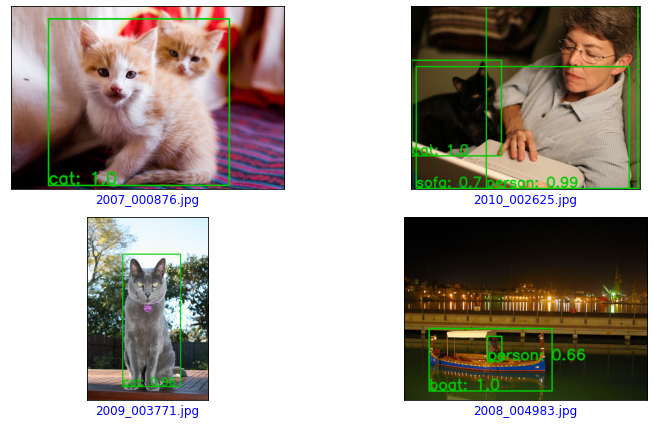

In [ ]:
ep=params_dict['epochs']
show_inference(model_.to('cpu'), test_loader, threshold=0.6, mask_thres=0.5,
               seg=segmentation, outdir=inference_dir, fname=f'{net_name}_{ep}')